# A Brief Introduction to Bayesian Data Analysis

<i>Version 2</i>

# WORK IN PROGRESS

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

## An Example

Suppose we conduct a real-world experiment consisting of a series of $n$ independent trials, where each trial will result in either a success or failure, and the probability of a success is an unknown value, $p$, where $0 \le p \le 1$.

> By the way, this type of experiment has a <b>Binomial($n$, $p$)</b> distribution. [See Wikipedia for more](https://en.wikipedia.org/wiki/Binomial_distribution)

Suppose further that, after conducting the $n$ trials, we observed a total of $k_{obs}$ successes. $0 \le k_{obs} \le n$.

We don't know the true value of $p$, but let's assume that $n$ and $k_{obs}$ have the following values:

In [2]:
n = 20  # Number of trials in our real-world experiment
k_obs = 6  # Number of observed successes in our real-world experiment

In [3]:
print(f"Then, an obvious estimate of p is k_obs/n = {k_obs}/{n} = {k_obs/n}")

Then, an obvious estimate of p is k_obs/n = 6/20 = 0.3


In <b>Frequentist</b> (or <b>Classical</b>) data analysis, this estimate is the <b>Maximum Likelihood Estimate (MLE)</b> of $p$.  We won't go into MLEs here, but let's just say that the MLE provides us with, in some sense, an optimal estimate of a fixed parameter.

### Going Beyond the Classical Approach

Suppose we're not satisfied with the MLE estimate.

Couldn't a value of $p=0.3127$ also result in $k_{obs}$ successes?

Yes.  In fact, since we're dealing with random behavior here, any value of $p$, where $0 \lt p \lt 1$, could result in $k_{obs}$ successes.

So, let's try some other values of $p$ -- a lot of other values -- and keep track of the ones that result in $k_{obs}$ successes.


To do this, we'll work with two lists of $p$'s:

* <b><i>priors</i></b>: a list of $m$ random numbers, chosen uniformly between 0 and 1

* <b><i>posteriors</i></b>: the subset of the priors that, when used in a simulation of n trials, result in $k_{obs}$ successes

We'll create the lists using just two lines of Python code, below.

For pedagogical reasons, the code is very simple.

It is definitely not the way to do this kind of simulation in practice.

Also, though it's easy to generate the priors list, the posteriors list takes longer, so we'll time it using <i>%time</i>.

And, we'll count the number of priors that result in $k_{obs}$ successes, because, as you will see, very few will, which is why such a large number of priors is used.

Later, we'll show how to use more efficient simulation methods, such as <b>Markov Chain Monte Carlo (MCMC)</b>, a method that has made Bayesian Data Analysis a practical tool.

In [4]:
from scipy.stats import uniform, binom

m = 1_000_000  # Number of priors

# Generate Priors and Posteriors
priors = list(uniform.rvs(size=m))
%time posteriors = [p for p in priors if binom.rvs(n,p)==k_obs]

print(f"\nThere were {len(posteriors)} matches out of {m} priors.")

CPU times: user 34.8 s, sys: 432 ms, total: 35.2 s
Wall time: 35 s

There were 47836 matches out of 1000000 priors.


Now, let's look at the two lists.

First, let's plot the lists as histograms, scaled to be density functions.

#### Priors Histogram

The histogram of the priors list should look like the Uniform(0,1) probabilty density function.

And it does.

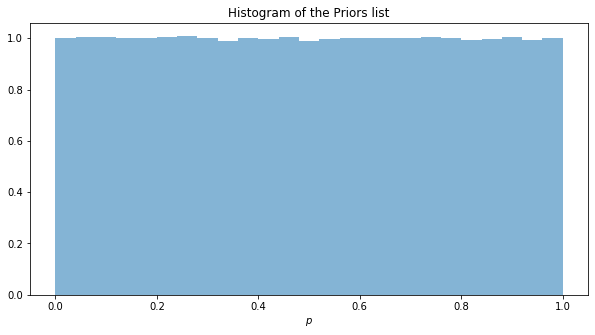

In [11]:
hbins = 25  # Number of bins for histograms
figsize(10,5)
plt.xlabel('$p$')
plt.title(f"Histogram of the Priors list")
_ = plt.hist(priors, bins=hbins, density=True, alpha=0.55)

#### Posteriors Histogram

The histogram of the posteriors list more interesting than the priors list.

We can see that it concentrates near the MLE value we computed earlier.

But, unlike the MLE, which is a point estimate of $p$, here we see a probability density function for $p$.

And we should, because, essentially, we assumed that $p$ is a random variable with a Uniform(0,1) distribution.

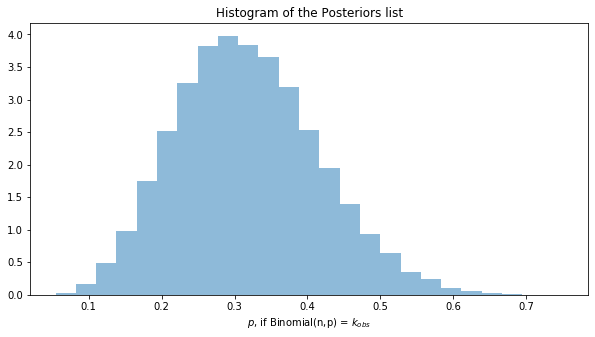

In [45]:
plt.xlabel('$p$, if Binomial(n,p) = $k_{obs}$')
plt.title(f"Histogram of the Posteriors list")
_ = plt.hist(posteriors, bins=hbins, density=True, alpha=0.5)

## Example Summary

We started by assuming we had conducted a Binomial($n$, $p$) experiment that resulted in $k_{obs}$ successes.

Then, instead of accepting the usual

In [53]:
round(14.56)

15

In [49]:
import fitdist as fd  # https://github.com/alreich/fitdist
import warnings
warnings.simplefilter('ignore')

fit_results = fd.find_best_fit_distributions(posteriors,
                                             dist_names = fd.common_cont_dist_names,
                                             goodness_of_fit_pvalue = 0.50,
                                             drop_dist_names = []
                                            )

In [50]:
fit_results

[['beta',
  (6.7448089653654515,
   14.57733916992553,
   0.005232044650990392,
   0.9883460538737286),
  0.9011287361165934]]

fitted MLE = (6.7448089653654515, 14.57733916992553, 0.005232044650990392, 0.9883460538737286)
MLE rounded to integer values = (7, 15, 0, 1)


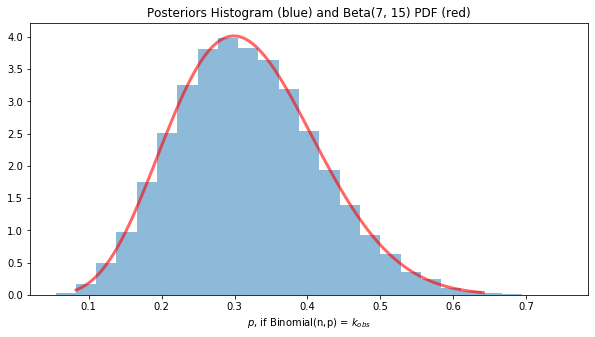

In [66]:
from scipy.stats import beta
from numpy import linspace

pos = 0
mle = fit_results[pos][1]
mle_rounded = tuple(map(lambda x: int(round(x)), mle))
_alpha, _beta, _, _ = mle_rounded
print(f'fitted MLE = {mle}')
print(f'MLE rounded to integer values = {mle_rounded}')

plt.xlabel('$p$, if Binomial(n,p) = $k_{obs}$')
#plt.title(f'Posteriors Histogram (blue) and Beta({_alpha:4.1f}, {_beta:4.1f}) PDF (red)')
plt.title(f'Posteriors Histogram (blue) and Beta({_alpha}, {_beta}) PDF (red)')

x = linspace(beta.ppf(0.001, *mle), beta.ppf(0.999, *mle), 100)
plt.plot(x, beta.pdf(x, *mle), 'r-', lw=3, alpha=0.6)
_, _, _ = plt.hist(posteriors, hbins, density=True, alpha=0.5)

In [62]:

mle_rounded

(7, 15, 0, 1)

The <b>Uniform(0,1)</b> prior, used above, is equivalent to a <b>Beta(1,1)</b> prior.  And, since the beta prior is conjugate with binomial likelihoods, the posterior should be a <b>Beta( 6 + 1, 20 - 6 + 1 ) = Beta(7,15)</b> which is close to what we obtained above.

Here's the math:

First of all, the Uniform distribution is equivalent to a Beta distribution:
<p><center>$U(0,1) \equiv Beta(1,1)$</center></p>
<p>Then, assuming the <i>prior</i> and the <i>likelihood</i> are as follows:</p>
<p><center><u>Prior</u>:  $\pi(\theta) \sim Beta(\alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$</center></p>
<p><center><u>Likelihood</u>:  $Y \sim Binomial(n,k,\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$</center></p>
<p>So, multiplying the two, followed by some algebraic manipulation, we arrive at:</p>
<p><center><u>Posterior</u>:  $\pi(\theta \mid Y=k) \sim Beta(k+\alpha, n-k+\beta)$</center></p>

# Scratch Work Below

## Introduction

How one conducts and interprets statistical inferences has been the subject of much debate for many decades.  In the 20th century, the debate was mostly over the <b>Frequentist</b> vs. the <b>Fisherian</b> approaches.  The <b>Bayesian</b> approach was also around during that time, but did not become practical until the 1990s with the advent of efficient simulation methods, such as <b>Markov Chain Monte Carlo (MCMC)</b>, and widespread access to powerful computers. Here, I'll refer the Frequentist and Fisherian approaches as the <b>Classical</b> approach. Today, the debate over how to conduct and interpret statistical inference is more about the Classical vs. Bayesian approaches.

The purpose of this notebook is to provide a brief look at <b>Bayesian Data Analysis (BDA)</b>.

To begin, statistical analyses can be viewed in terms of the mathematical assumptions they make. Three broad categories are listed below, where each one makes successively greater assumptions than the previous one:
1. <b>Exploratory Data Analysis</b> -- No probability model; just descriptive statistics
1. <b>Classical Data Analysis</b> -- Probability model with fixed parameter
1. <b>Bayesian Data Analysis</b> -- Probability model with random parameter, with its own model & fixed <i>hyper-parameter</i>

The following three subsections go into a bit more depth on each of these three categories.

### 1. Exploratory Data Analysis

No probability model.

#### Examples

* Average
* Median
* Quantiles
* Range
* Minimum/Maximum
* Histogram 

### 2. Classical Data Analysis

The probability model consists of a random variable, $X$, with a probability distribution, $F$ and a fixed parameter $\theta$:

$X \sim F(x;\theta)$


#### Example #2

<i><u>Discrete Case</u></i>

In this example the outcomes are integer values, so we'll use $K$ and $k$ instead of $X$ and $x$ for the random variable and its outcome value, resp.

The <b>binomial probability distribution</b>, $Binomial_n(k;\theta)$, is a discrete distribution representing the probability of $k$ successes in $n$ independent trials, where the probability of success on each individual trial is $\theta$, where $0 \le \theta \le 1$.

then $K \sim Binomial_n(k;\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$
> <p>where</p>
> <p>$n \in \{1,2,3,...\}$ -- The fixed number of trials</p>
> <p>$k \in \{0,1,2,...,n\}$ -- Number of successes in n trials (the outcome)</p>
> <p>$\theta \in [0,1]$ -- The fixed probability of success for each trial</p>


### 3. Bayesian Data Analysis

<i>(NOTE: This starts out like the Classical approach, except that it goes a step further by assuming that the parameter itself, $\theta$, has a model.)</i>

Assumes a random variable, $X$, with a specific probability distribution, $F$, and <b>random</b> parameter, $\Theta$, with its own distribution, $G$, and fixed parameter, $\gamma$, sometimes called a hyper-parameter:

$X \sim F(x;\Theta)$ where $\Theta \sim G(\theta;\gamma)$

$G$ is called a <b><i>prior</i></b> distribution.

#### Example #3

<i><u>Discrete Case</u></i>

Building on the discrete model in Example #2, above, except that instead of a fixed success probability, $\theta$, here it is assumed to be a random variable, $\Theta$, with its own distribution, a <b>Beta distribution</b>, $Beta(\theta; \alpha, \beta)$, where $\theta \in [0,1]$, $\alpha > 0$, and $\beta > 0.$

$K \sim Binomial_n(k; \Theta) \equiv \binom{n}{k} \Theta^k(1-\Theta)^{n-k}$

$\Theta \sim Beta(\theta; \alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$

> <p>where</p>
> <p>$n \in \{1,2,3,...\}$ -- Number of trials (a fixed value)</p>
> <p>$k \in \{0,1,2,...,n\}$ -- Number of successes</p>
> <p>$\theta \in [0,1]$ -- The fixed probability of success for each trial
> <p>$\alpha > 0$ and $\beta > 0$</p>

## Scatch Work

<b><i>Probability Theory</i></b> is a subfield of Mathematics that is concerned with mathematical models of random phenomena.


<i><b>Mathematical Statistics</b></i> is a subfield of Probability Theory concerned with the derivation of features of a probability model based on a set of <b>Random Variables (RV)</b> from the model.

<i><b>Applied Statistics</b></i> utilizes the results of Mathematical Statistics by replacing the set of RVs with actual observed data to make <b>statistical inferences</b>.